Use xESMF's locstream option to remap unstructured CMIP6 data
================

## with the nearest-neighbour method ('nearest_s2d')
### Example for ICON-ESM (ICON-OES) and AWI-CM (FESOM) 

### Basic Imports

In [1]:
import psyplot.project as psy
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import sparse as sps
import xarray as xr
import xesmf as xe
print("Using xESMF in version %s" % xe.__version__)
#print(xe.__file__)

%matplotlib inline
%config InlineBackend.close_figures = False

import warnings
warnings.simplefilter("ignore") 
#with warnings.catch_warnings():
#        warnings.simplefilter("ignore")

xr.set_options(display_style='html');

Using xESMF in version 0.6.1


### Load the dataset

In [2]:
pool_path="/pool/data/CMIP6/data"

drs_path_icon="CMIP/MPI-M/ICON-ESM-LR/historical/r1i1p1f1/Omon/tos/gn/v20210215"
ifile_icon="tos_Omon_ICON-ESM-LR_historical_r1i1p1f1_gn_185001-185912.nc"
# On mistral
#ds_path_icon=pool_path+"/"+ds_path_icon+"/"+ifile_icon
# Locally
ds_path_icon=ifile_icon
ds_icon = xr.open_dataset(ds_path_icon).isel(time=0)

drs_path_awicm="CMIP/AWI/AWI-CM-1-1-MR/historical/r1i1p1f1/Omon/tos/gn/v20181218/"
ifile_awicm="tos_Omon_AWI-CM-1-1-MR_historical_r1i1p1f1_gn_185001-185012.nc"
# On mistral
#ds_path_awicm=pool_path+"/"+ds_path_awicm+"/"+ifile_awicm
# Locally
ds_path_awicm=ifile_awicm
ds_awicm = xr.open_dataset(ds_path_awicm).isel(time=0)

In [3]:
ds_icon

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 235403, vertices: 3)
Coordinates:
    time                datetime64[ns] 1850-01-16T12:00:00
  * i                   (i) int32 0 1 2 3 4 ... 235399 235400 235401 235402
    latitude            (i) float64 ...
    longitude           (i) float64 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (bnds) datetime64[ns] ...
    vertices_latitude   (i, vertices) float64 ...
    vertices_longitude  (i, vertices) float64 ...
    tos                 (i) float32 ...
Attributes: (12/50)
    CDI_grid_type:          unstructured
    CDO:                    Climate Data Operators version 2.0.0rc5 (https://...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    ...                     ...
    title:                  ICON-ESM-LR output prepared for CMIP6
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.6.0
    tracking_id:            hdl:21.14100/1a18fd0a-7d3d-486f-b31d-f9780b8dbf0a

In [4]:
ds_awicm

<xarray.Dataset>
Dimensions:    (bnds: 2, ncells: 830305, vertices: 16)
Coordinates:
    time       datetime64[ns] 1850-01-16T12:00:00
    lat        (ncells) float64 ...
    lon        (ncells) float64 ...
Dimensions without coordinates: bnds, ncells, vertices
Data variables:
    time_bnds  (bnds) datetime64[ns] ...
    tos        (ncells) float32 ...
    lat_bnds   (ncells, vertices) float64 ...
    lon_bnds   (ncells, vertices) float64 ...
Attributes: (12/39)
    frequency:              mon
    activity_id:            CMIP
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-12-18T12:00:00Z
    data_specs_version:     01.00.27
    experiment:             historical
    ...                     ...
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       AWI-CM-1-1-MR
    parent_time_units:      days since 2401-1-1
    parent_variant_label:   r1i1p1f1

### Plot the grid

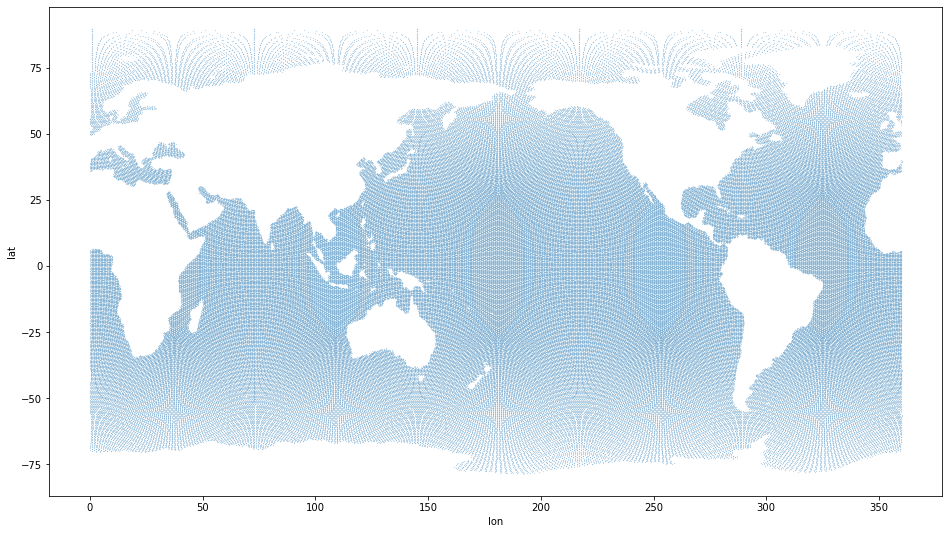

In [5]:
# plot grid
plt.figure(figsize=(16,9))
plt.scatter(ds_icon['longitude'], ds_icon['latitude'], s=0.01)  
plt.xlabel('lon');
plt.ylabel('lat');

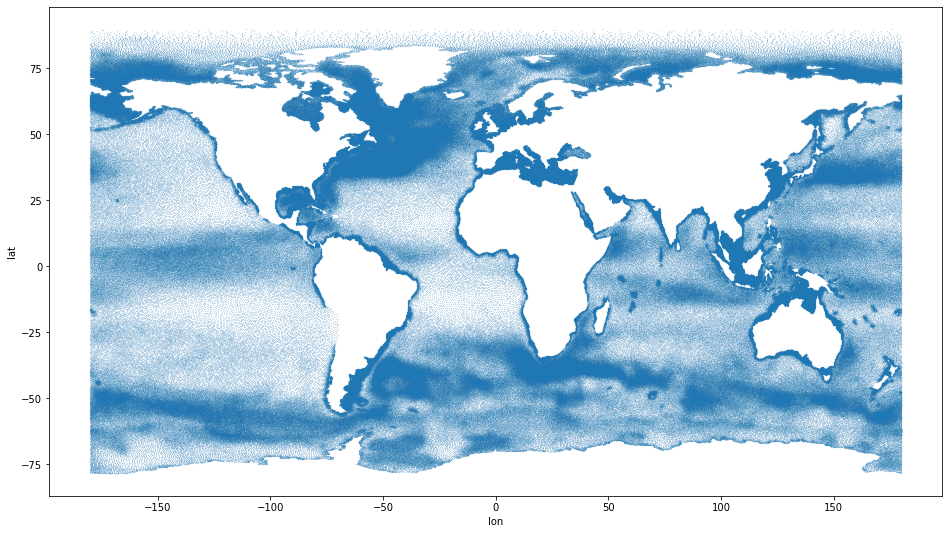

In [6]:
# plot grid
plt.figure(figsize=(16,9))
plt.scatter(ds_awicm['lon'], ds_awicm['lat'], s=0.01)  
plt.xlabel('lon');
plt.ylabel('lat');

### Plot the data

In [7]:
# Using psyplot
psy.rcParams['plotter.maps.xgrid'] = False
psy.rcParams['plotter.maps.ygrid'] = False
mpl.rcParams['figure.figsize'] = [10., 8.]

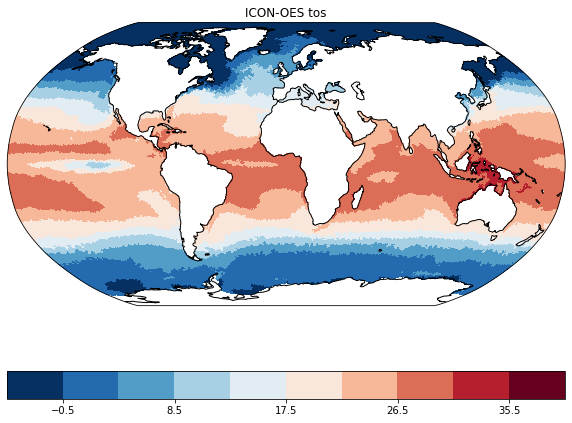

In [8]:
maps=psy.plot.mapplot(ifile_icon, 
                      name="tos", projection="robin",cmap="RdBu_r", 
                      title="ICON-OES tos", time=[0])

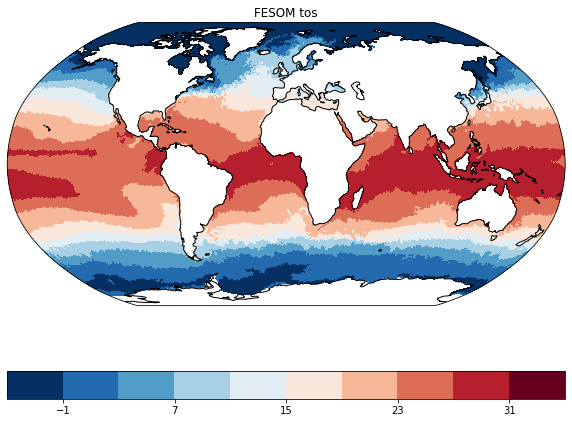

In [9]:
maps=psy.plot.mapplot(ifile_awicm, 
                      name="tos", projection="robin",cmap="RdBu_r", 
                      title="FESOM tos", time=[0])

### Set up the destination grid

In [10]:
# Specify a global 1 deg grid
ds_out = xe.util.grid_global(1,1) # global 1 degree grid

### Calculate the distances

In [11]:
from scipy.spatial import cKDTree

def lon_lat_to_cartesian(lon, lat, R = 6371000):
    """
    # Taken from FESOM/pyfesom - https://github.com/FESOM/pyfesom/blob/master/pyfesom/regriding.py
    
    Calculates lon, lat coordinates of a point on a sphere with
    radius R. Taken from http://earthpy.org/interpolation_between_grids_with_ckdtree.html
    Parameters
    ----------
    lon : 1d array
        longitudes
    lat : 1d array
        latitudes
    R   : float
        radius of the sphere
    Returns
    -------
    x,y,z : 1d arrays
        cartesian coordinates
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x =  R * np.cos(lat_r) * np.cos(lon_r)
    y =  R * np.cos(lat_r) * np.sin(lon_r)
    z =  R * np.sin(lat_r)
    return x,y,z

def create_indexes_and_distances(lon_in, lat_in, lon_out, lat_out, n_jobs=2,):
    '''
    # Adapted from FESOM/pyfesom - https://github.com/FESOM/pyfesom/blob/master/pyfesom/regriding.py
    
    Creates KDTree object and queries it for indexes of points in source grid that are closest to the
    points of the target grid. Also returns distances between the selected original points and target points
    as well as the average spacing of the source grid points.
 
    Parameters
    ----------
    lon_in/lat_in : array
        2d arrays with source grid values.
    lon_out/lat_out : array
        2d arrays with target grid values.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    Returns
    -------
    distances : array of floats
        The distances to the nearest neighbors. 
    inds : ndarray of ints
        The locations of the neighbors in data.  
    approx_res: float
        Approximate grid_spacing
    '''
    # Required for 1D coordinate variables in a lat-lon grid
    # Not required for an unstructured grid with 1D coordinate variables
    #if len(lon_in.shape)==1:
    #    lon_in, lat_in = np.meshgrid(lon_in, lat_in)
    #if len(lon_out.shape)==1:
    #    lon_out, lat_out = np.meshgrid(lon_out, lat_out)
    
    xs, ys, zs = lon_lat_to_cartesian(lon_in.flatten(), lat_in.flatten())
    xt, yt, zt = lon_lat_to_cartesian(lon_out.flatten(), lat_out.flatten()) 
    
    # Calculate shortest distances between destination and source grid points
    tree = cKDTree(list(zip(xs, ys, zs)))
    distances, inds = tree.query(list(zip(xt, yt, zt)), k = 1, n_jobs=n_jobs)
    
    # Calculate average spacing of source grid points
    approx_res = np.average(tree.query(list(zip(xs, ys, zs)), k = 2, n_jobs=n_jobs)[0][:, 1])

    return distances, inds, approx_res

In [12]:
# Calculate the distances to the nearest source cells
dist_icon,ind_icon,res_icon = create_indexes_and_distances(ds_icon.longitude.values,
                                                           ds_icon.latitude.values,
                                                           ds_out.lon.values,
                                                           ds_out.lat.values)

dist_awicm, ind_awicm, res_awicm = create_indexes_and_distances(ds_awicm.lon.values,
                                                                ds_awicm.lat.values,
                                                                ds_out.lon.values,
                                                                ds_out.lat.values)

### Create remapped dataset by hand, as reference

In [13]:
# nearest neighbour regridding function
# adapted from FESOM/pyfesom function fesom2regular
# - result serves as reference
def locstream2regular(data, lon, lat, distances=None, \
                  inds=None, radius_of_influence=100000, n_jobs = 2 ):
    '''
    Interpolates data from locstream 1d arrays to target.
    Parameters
    ----------
    data : array
        1d array that represents data at one level.
    lons/lats : array
        2d arrays with target grid values.
    distances : array of floats, optional
        The distances to the nearest neighbors.
    inds : ndarray of ints, optional
        The locations of the neighbors in data.    
    radius_of_influence : int
        Cut off distance in meters.
    n_jobs : int, optional
        Number of jobs to schedule for parallel processing. If -1 is given
        all processors are used. Default: 1.
    
    Returns
    -------
    data_interpolated : 2d array
        array with data interpolated to the target grid.
    '''
    #print distances
    if (distances is None) or (inds is None):        
        distances, inds, res = create_indexes_and_distances(lon, lat, k=1, n_jobs=n_jobs)
        
    data_interpolated = data[inds]

    data_interpolated[distances>=radius_of_influence] = np.nan
        
    if lon.ndim == 1:
        data_interpolated = data_interpolated.reshape((lat.shape[0], lon.shape[0]))
    else:
        data_interpolated = data_interpolated.reshape(lon.shape)
    data_interpolated = np.ma.masked_invalid(data_interpolated)
    
    return data_interpolated

In [14]:
print("ICON-ESM OES approx. resolution [m]:",res_icon)
print("AWI-CM FESOM approx. resolution [m]:", res_awicm)

ICON-ESM OES approx. resolution [m]: 30124.379763968183
AWI-CM FESOM approx. resolution [m]: 17364.189333497867


In [15]:
ds_out["tos_nn_icon"]=xr.DataArray(data=locstream2regular(ds_icon["tos"].data, ds_out["x"].data, ds_out["y"].data,
                                                          distances=dist_icon, inds=ind_icon,
                                                          radius_of_influence=2*res_icon),
                                   dims=(("y", "x")))

In [16]:
ds_out["tos_nn_awicm"]=xr.DataArray(data=locstream2regular(ds_awicm["tos"].data, ds_out["x"].data, ds_out["y"].data,
                                                           distances=dist_awicm, inds=ind_awicm,
                                                           radius_of_influence=3*res_awicm),
                                    dims=(("y", "x")))

### Create output mask to mask out-of-source-domain / unmapped grid cells of the target grid

Due to the locally varying resolution of the FESOM grid it does not work too well creating a mask for a fixed `radius_of_influence`.

When using the kwargs `locstream_in=True` or `locstream_out=True` the `xesmf.Regridder` does not forward the mask to ESMF when generating the weights, because there exists a bug that causes ESMF to crash in that specific application.
The masks therefore have to be applied manually to the regridded result or the weights have to be manipulated after their generation.

In [17]:
# Create the mask by masking target grid cells that are located >= 2 * res of a source grid cell
mask_icon=np.where(dist_icon>=res_icon*2, False, True).reshape(180,360)
mask_awicm=np.where(dist_awicm>=res_awicm*3, False, True).reshape(180,360) #factor set to 3 for FESOM

# Copy the output grid as reference
ds_out_icon = ds_out.copy()
ds_out_awicm= ds_out.copy()

# Specify the created mask as output mask 
ds_out_icon['mask']=xr.DataArray(data=mask_icon, dims=["y", "x"])
ds_out_awicm['mask']=xr.DataArray(data=mask_awicm, dims=["y", "x"])

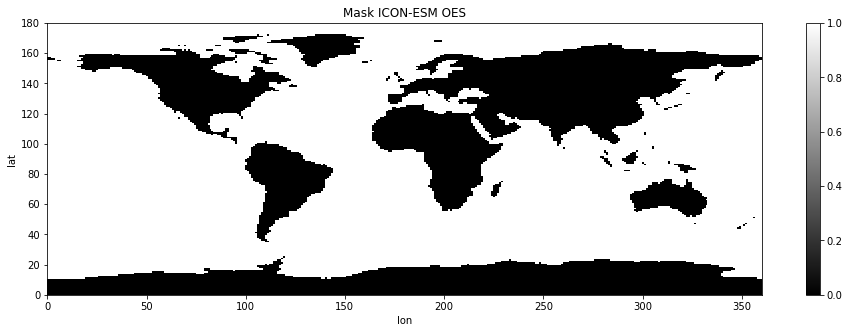

In [18]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(16,5))
im=axes.pcolormesh(ds_out_icon['mask'], cmap="binary_r")
fig.colorbar(im, ax=axes)
axes.set_xlabel('lon');
axes.set_ylabel('lat');
axes.set_title('Mask ICON-ESM OES');

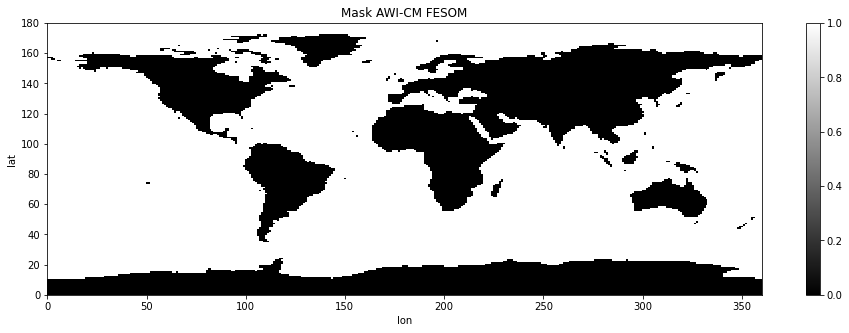

In [19]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(16,5))
im=axes.pcolormesh(ds_out_awicm['mask'], cmap="binary_r")
fig.colorbar(im, ax=axes)
axes.set_xlabel('lon');
axes.set_ylabel('lat');
axes.set_title('Mask AWI-CM FESOM');

### Calculate the regridding weights

Creating two sets of weights, one of which will be manipulated in a next step to directly apply the target grid mask to the weights.

In [20]:
# Create regridding weights incl. and excl. the specified output mask
#  - add_nans_to_weights is applied by default
def regrid(ds_in, ds_out, method='nearest_s2d', locstream_in=True):
    """Convenience function for calculating regridding weights"""
    return xe.Regridder(ds_in, ds_out, method, locstream_in)

# Just looking at nearest_s2d
# method_list = ['bilinear','nearest_s2d', 'conservative', 'conservative_normed', 'patch']
method_list = ['nearest_s2d']

regridder={}
for method in method_list:
    # ICON-ESM OES
    print()
    %time regridder[method+"_icon"]=regrid(ds_icon, ds_out_icon, method)
    regridder[method+"_icon_manp"]=regrid(ds_icon, ds_out_icon, method)
    print(regridder[method+"_icon"])
    
    # AWI-CM FESOM
    print()
    %time regridder[method+"_awicm"]=regrid(ds_awicm, ds_out_awicm, method)
    regridder[method+"_awicm_manp"]=regrid(ds_awicm, ds_out_awicm, method)
    print(regridder[method+"_awicm"])


CPU times: user 612 ms, sys: 28.3 ms, total: 640 ms
Wall time: 658 ms
xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_1x235403_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1, 235403) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False

CPU times: user 1.76 s, sys: 36 ms, total: 1.8 s
Wall time: 1.8 s
xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_1x830305_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (1, 830305) 
Output grid shape:          (180, 360) 
Periodic in longitude?      False


### Manipulate one set of the weights to apply the target grid mask

Altering the xESMF function `smm.add_nans_to_weights` to take a mask for the target grid as argument.

In [21]:
def add_nans_to_weights_and_mask(weights, mask_out):
    """Add NaN in empty rows of the regridding weights sparse matrix.

    By default, empty rows in the weights sparse matrix are interpreted as zeroes. This can become problematic
    when the field being interpreted has legitimate null values. This function inserts NaN values in each row to
    make sure empty weights are propagated as NaNs instead of zeros.

    Parameters
    ----------
    weights : DataArray backed by a sparse.COO array
      Sparse weights matrix.
    mask_out: numpy.array of type bool or int
       with shape of the (flattened) output grid.

    Returns
    -------
    DataArray backed by a sparse.COO array
      Sparse weights matrix.
    """

    # Taken from @trondkr and adapted by @raphaeldussin to use `lil`.
    # lil matrix is better than CSR when changing sparsity
    M = weights.data.to_scipy_sparse().tolil()    
    
    # Create "unmapped" cells out of all masked target grid cells
    # This should probably not be used with conservative_normed (and nearest_d2s?) method.
    # I tested it yet only for nearest_s2d.    
    tozero=np.where(mask_out.ravel()==0)[0]
    for krow in tozero:
        M.rows[krow]=[0]
        M.data[krow]=[np.NaN]
    
    # replace empty rows by one NaN value at element 0 (arbitrary)
    # so that remapped element become NaN instead of zero
    for krow in range(len(M.rows)):
        M.rows[krow] = [0] if M.rows[krow] == [] else M.rows[krow]
        M.data[krow] = [np.NaN] if M.data[krow] == [] else M.data[krow]
    # update regridder weights (in COO)
    weights = weights.copy(data=sps.COO.from_scipy_sparse(M))
    return weights

In [22]:
%%time 
regridder["nearest_s2d_icon_manp"].weights=add_nans_to_weights_and_mask(
    regridder["nearest_s2d_icon_manp"].weights, mask_icon
)
regridder["nearest_s2d_awicm_manp"].weights=add_nans_to_weights_and_mask(
    regridder["nearest_s2d_awicm_manp"].weights, mask_awicm
)

CPU times: user 403 ms, sys: 0 ns, total: 403 ms
Wall time: 402 ms


### Perform the regridding

In [23]:
# Perform regridding
for method in method_list:
    # ICON-ESM OES
    ds_out["tos_icon_"+method]=regridder[method+"_icon"](ds_icon.tos)
    ds_out["tos_icon_"+method+"_manp"]=regridder[method+"_icon_manp"](ds_icon.tos)
    # AWI-CM FESOM
    ds_out["tos_awicm_"+method]=regridder[method+"_awicm"](ds_awicm.tos)
    ds_out["tos_awicm_"+method+"_manp"]=regridder[method+"_awicm_manp"](ds_awicm.tos)

### Plot regridded data

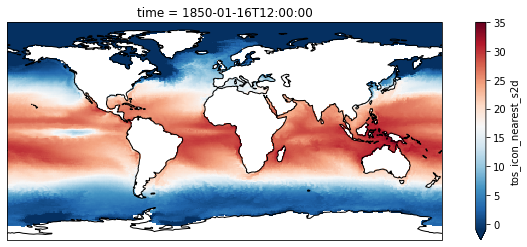

In [24]:
# ICON-ESM OES - unmasked
# For ICON-ESM OES data, there seem to be source grid cells above land near the coast that are defined as np.nan
#  while the majority of land is unmapped (see plot of the grid above). This causes the target grid cells over 
#  land to already be masked without applying any mask manually.
plt.figure(figsize=(12,4));
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.Robinson())
ds_out["tos_icon_nearest_s2d"].plot.pcolormesh(ax=ax, x='lon', y='lat', vmin=-1, vmax=35, cmap="RdBu_r");
ax.coastlines();

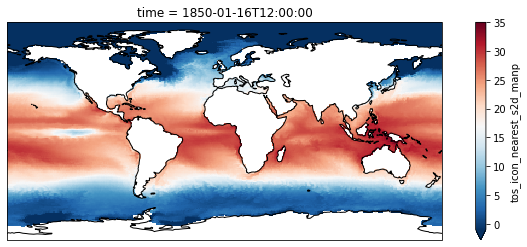

In [25]:
# ICON-ESM OES - masked through manipulated weights
plt.figure(figsize=(12,4));
ax = plt.axes(projection=ccrs.PlateCarree())
ds_out["tos_icon_nearest_s2d_manp"].plot.pcolormesh(ax=ax, x='lon', y='lat', vmin=-1, vmax=35, cmap="RdBu_r");
ax.coastlines();

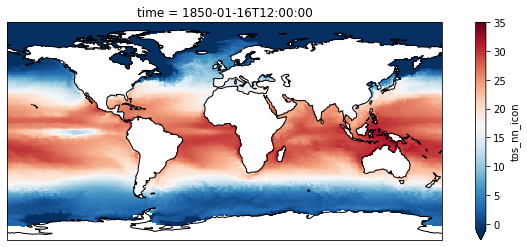

In [26]:
# ICON-ESM OES - reference
plt.figure(figsize=(12,4));
ax = plt.axes(projection=ccrs.PlateCarree())
ds_out["tos_nn_icon"].plot.pcolormesh(ax=ax, x='lon', y='lat', vmin=-1, vmax=35, cmap="RdBu_r");
ax.coastlines();

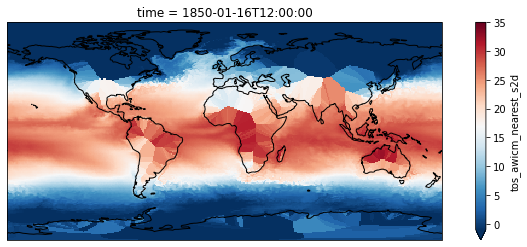

In [27]:
# AWI-CM FESOM - unmasked
# For AWI-CM FESOM there are no defined source grid cells over land (unmapped),
#  so target grid cells on land take the value of the nearest ocean cell at the coast.
plt.figure(figsize=(12,4));
ax = plt.axes(projection=ccrs.PlateCarree())
ds_out["tos_awicm_nearest_s2d"].plot.pcolormesh(ax=ax, x='lon', y='lat', vmin=-1, vmax=35, cmap="RdBu_r");
ax.coastlines();

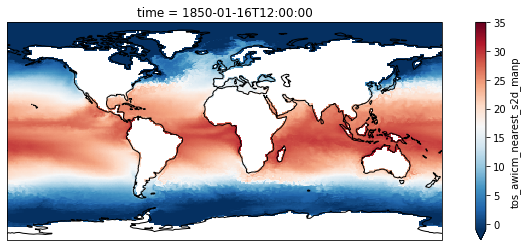

In [28]:
# AWI-CM FESOM - masked through manipulated weights
plt.figure(figsize=(12,4));
ax = plt.axes(projection=ccrs.PlateCarree())
ds_out["tos_awicm_nearest_s2d_manp"].plot.pcolormesh(ax=ax, x='lon', y='lat', vmin=-1, vmax=35, cmap="RdBu_r");
ax.coastlines();

In [29]:
# Applying the mask after the regridding process
ds_out['tos_awicm_nearest_s2d_masked']=xr.where(
    ds_out_awicm['mask'].values==1, 
    ds_out["tos_awicm_nearest_s2d"], 
    np.nan)

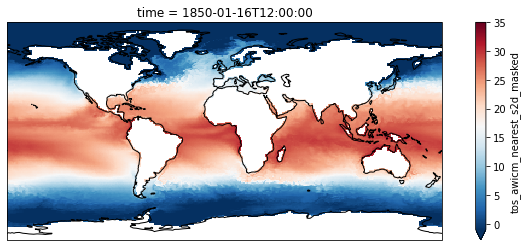

In [30]:
# AWI-CM FESOM - masked - mask applied after regridding process
plt.figure(figsize=(12,4));
ax = plt.axes(projection=ccrs.PlateCarree())
ds_out["tos_awicm_nearest_s2d_masked"].plot.pcolormesh(ax=ax, x='lon', y='lat', vmin=-1, vmax=35, cmap="RdBu_r");
ax.coastlines();

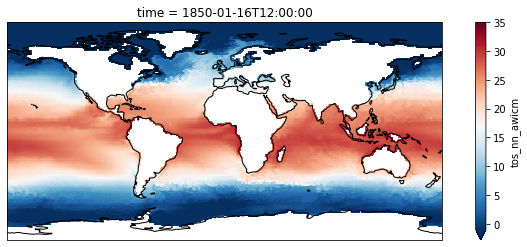

In [31]:
# AWI-CM FESOM - reference - mask applied during regridding process
plt.figure(figsize=(12,4));
ax = plt.axes(projection=ccrs.PlateCarree())
ds_out["tos_nn_awicm"].plot.pcolormesh(ax=ax, x='lon', y='lat', vmin=-1, vmax=35, cmap="RdBu_r");
ax.coastlines();

### Difference between xESMF (`method=nearest_s2d` with `locstream_in=True`) and "manual" nearest neighbour remapping

There is no difference.

In [32]:
ds_out["tos_awicm_diff"] = ds_out["tos_nn_awicm"] - ds_out["tos_awicm_nearest_s2d_masked"]

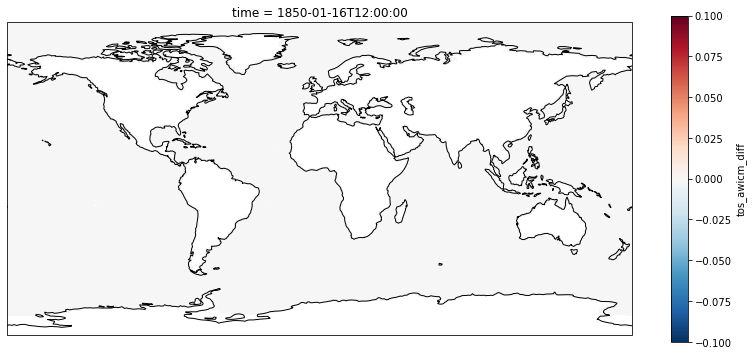

In [33]:
plt.figure(figsize=(14,6));
ax = plt.axes(projection=ccrs.PlateCarree())
ds_out["tos_awicm_diff"].plot.pcolormesh(ax=ax, x='lon', y='lat', vmin=-.1, vmax=.1, cmap="RdBu_r");
ax.coastlines();

The disadvantage in using `locstream_in=True` is that masks for the input or output fields are ignored.
In that regard it might be a useful addition to allow the user to provide a mask for the output field when applying the remapping weights, eg. `ds_out=regridder(ds_in, mask_out, [skip_na, na_thresh])`. It might also be useful to not ignore the mask when `locstream_in=True` or `locstream_out=True` are set, and manipulate the weights after their generation similar to the function `smm.add_nans_to_weights` with the addition of explicitly setting the weights of the masked target grid cells to `np.nan`.